In [196]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Machine Learning tools

In [198]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn import metrics
from scipy.stats import uniform, randint
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [199]:
df = pd.read_csv('/content/drive/My Drive/ML Assignment/TSLA.csv')
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-09-30,48.796001,47.222000,48.599998,48.174000,29399000.0,48.174000
1,2019-10-01,49.189999,47.826000,48.299999,48.938000,30813000.0,48.938000
2,2019-10-02,48.930000,47.886002,48.658001,48.625999,28157000.0,48.625999
3,2019-10-03,46.896000,44.855999,46.372002,46.605999,75422500.0,46.605999
4,2019-10-04,46.956001,45.613998,46.321999,46.285999,39975000.0,46.285999


In [200]:
df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
634,2022-04-05,1152.869995,1087.300049,1136.300049,1091.260010,26691700.0,1091.260010
635,2022-04-06,1079.000000,1027.699951,1073.469971,1045.760010,29782800.0,1045.760010
636,2022-04-07,1076.589966,1021.539978,1052.390015,1057.260010,26482400.0,1057.260010
637,2022-04-08,1048.439941,1022.440002,1043.209961,1025.489990,18293300.0,1025.489990
638,2022-04-11,1008.469971,974.640015,980.400024,975.929993,19660500.0,975.929993


In [201]:
df.shape

(639, 7)

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       639 non-null    object 
 1   High       639 non-null    float64
 2   Low        639 non-null    float64
 3   Open       639 non-null    float64
 4   Close      639 non-null    float64
 5   Volume     639 non-null    float64
 6   Adj Close  639 non-null    float64
dtypes: float64(6), object(1)
memory usage: 35.1+ KB


In [203]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,639.000000,639.000000,639.000000,639.000000,6.390000e+02,639.000000
mean,543.362885,517.883537,531.004088,531.298030,4.819130e+07,531.298030
std,340.837426,325.395864,333.534448,333.362040,3.579030e+07,333.362040
min,46.896000,44.855999,45.959999,46.285999,9.800600e+06,46.285999
25%,170.258003,162.379997,167.349998,164.783005,2.392195e+07,164.783005
50%,620.409973,595.500000,603.880005,605.130005,3.448900e+07,605.130005
75%,796.584991,767.744995,779.445007,781.304993,6.329725e+07,781.304993
max,1243.489990,1217.000000,1234.410034,1229.910034,3.046940e+08,1229.910034


Feature engineering

In [204]:
df['Price Change'] = df['Close'] - df['Open']
df['Price Direction'] = np.where(df['Price Change'] > 0, 1, 0)

In [205]:
X = df[['High', 'Low', 'Open', 'Close', 'Volume']]
y = df['Price Direction']

Scaling features

In [206]:
scaler = StandardScaler()

In [207]:
X_scaled = scaler.fit_transform(X)

Train-validation-test split

In [208]:
train_size = int(len(df) * 0.7)  # 70% training
valid_size = int(len(df) * 0.15)  # 15% validation
test_size = len(df) - train_size - valid_size

In [209]:
X_train, X_valid, X_test = X_scaled[:train_size], X_scaled[train_size:train_size + valid_size], X_scaled[train_size + valid_size:]
y_train, y_valid, y_test = y[:train_size], y[train_size:train_size + valid_size], y[train_size + valid_size:]

Check the class distribution

In [210]:
class_counts = df['Price Direction'].value_counts()
print("Class Distribution:")
print(class_counts)

Class Distribution:
Price Direction
1    331
0    308
Name: count, dtype: int64


Visualize the class distribution

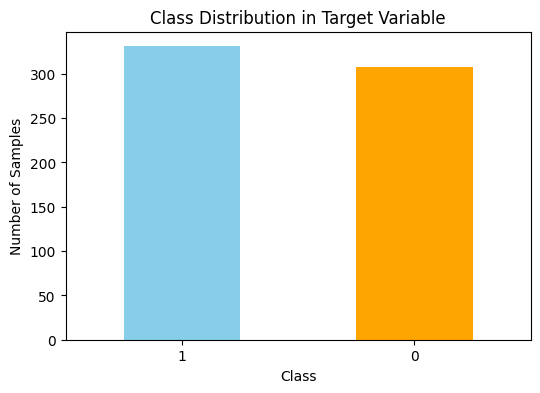

In [211]:
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Class Distribution in Target Variable")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.show()


Calculate the imbalanced ratio

In [212]:
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")


Imbalance Ratio: 1.07


In [213]:
if imbalance_ratio > 1.5:
    print("The dataset is imbalanced.")
else:
    print("The dataset is balanced.")

The dataset is balanced.


Apply SMOTE to balance the classes in the training set

In [214]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Apply Tomek Links to remove noise and refine boundaries

In [215]:
tomek = TomekLinks()
X_train_res, y_train_res = tomek.fit_resample(X_train_res, y_train_res)

Hyperparameter tuning using RandomizedSearchCV for SVM

In [216]:
param_dist = {
    'C': uniform(0.1, 10),  # generate random values between 0.1 and 10
    'gamma': ['scale', 'auto', 0.1, 0.5, 1],  # Gamma values for kernel
    'kernel': ['linear'],  # Different kernel types
    'class_weight': ['balanced', None],
    'degree': [3],  # Degree for polynomial kernel
    'tol': [1e-3, 1e-4]  # Tolerance for stopping criterion
}

Time series split for time series validation

In [217]:
tscv = TimeSeriesSplit(n_splits=3)  #Avoid data leakage

Perform RandomizedSearchCV for SVM

In [218]:
random_search = RandomizedSearchCV(SVC(probability=True), param_distributions=param_dist, n_iter=100, cv=tscv, scoring='roc_auc', random_state=42, n_jobs=-1)
random_search.fit(X_train_res, y_train_res)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=SVC(probability=True), n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bae2275f850>,
                                        'class_weight': ['balanced', None],
                                        'degree': [3],
                                        'gamma': ['scale', 'auto', 0.1, 0.5, 1],
                                        'kernel': ['linear'],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, scoring='roc_auc')

Best model from RandomizedSearchCV

In [219]:
best_model_svm = random_search.best_estimator_
print("\nBest Parameters from RandomizedSearchCV:", random_search.best_params_)


Best Parameters from RandomizedSearchCV: {'C': 9.494989415641891, 'class_weight': None, 'degree': 3, 'gamma': 0.5, 'kernel': 'linear', 'tol': 0.0001}


Train the best SVM model

In [220]:
best_model_svm.fit(X_train_res, y_train_res)

SVC(C=9.494989415641891, gamma=0.5, kernel='linear', probability=True,
    tol=0.0001)

Evaluate model on validation set

In [221]:
y_pred_svm = best_model_svm.predict(X_valid)

In [222]:
y_pred_proba_svm = best_model_svm.predict_proba(X_valid)[:, 1]

Evaluate model on test set

In [223]:
y_test_pred = best_model_svm.predict(X_test)
y_test_proba = best_model_svm.predict_proba(X_test)[:, 1]

Print classification report

In [224]:
print("\nClassification Report (Validation Data):")
print(classification_report(y_valid, y_pred_svm))


Classification Report (Validation Data):
              precision    recall  f1-score   support

           0       0.67      0.95      0.79        43
           1       0.94      0.62      0.74        52

    accuracy                           0.77        95
   macro avg       0.81      0.78      0.77        95
weighted avg       0.82      0.77      0.76        95



In [225]:
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred))


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        46
           1       0.98      0.98      0.98        51

    accuracy                           0.98        97
   macro avg       0.98      0.98      0.98        97
weighted avg       0.98      0.98      0.98        97



Reduce to 3 Principal components

In [226]:
pca = PCA(n_components=3)   #For demensionality reduction and faster training

In [227]:
X_scaled_pca = pca.fit_transform(X_scaled)

Compute AUC and plot ROC curve

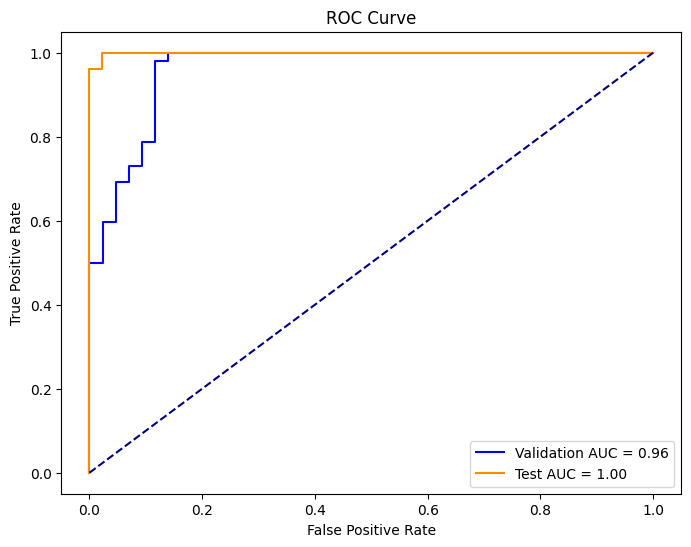

In [228]:
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_svm)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

roc_auc_valid = auc(fpr_valid, tpr_valid)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_valid, tpr_valid, label=f'Validation AUC = {roc_auc_valid:.2f}', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {roc_auc_test:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Plot precision-Recall curve

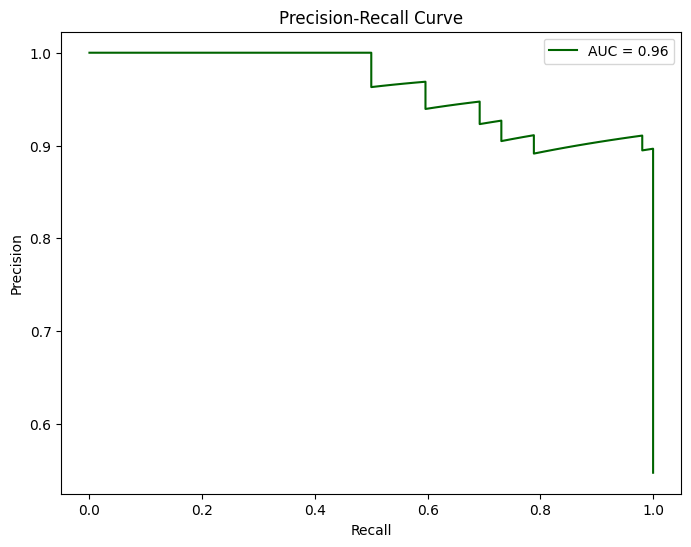

In [229]:
precision, recall, _ = precision_recall_curve(y_valid, y_pred_proba_svm)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {auc(recall, precision):.2f}', color='darkgreen')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

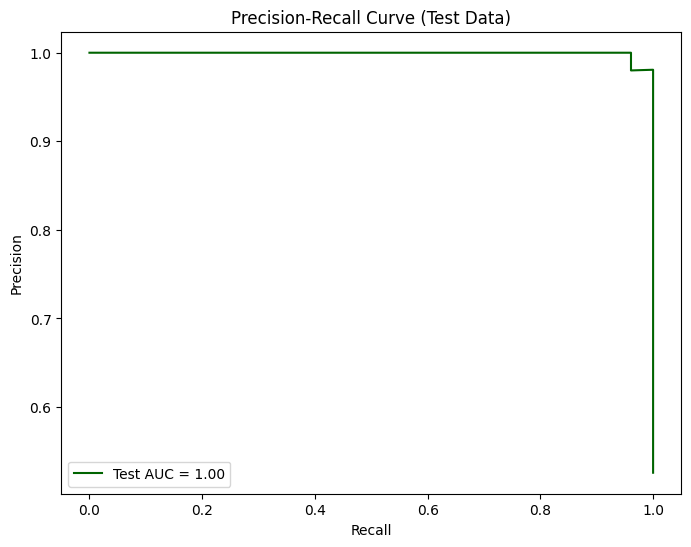

In [230]:
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_test, precision_test, label=f'Test AUC = {auc(recall_test, precision_test):.2f}', color='darkgreen')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test Data)')
plt.legend(loc='best')
plt.show()

Confusion Matrix for validation data

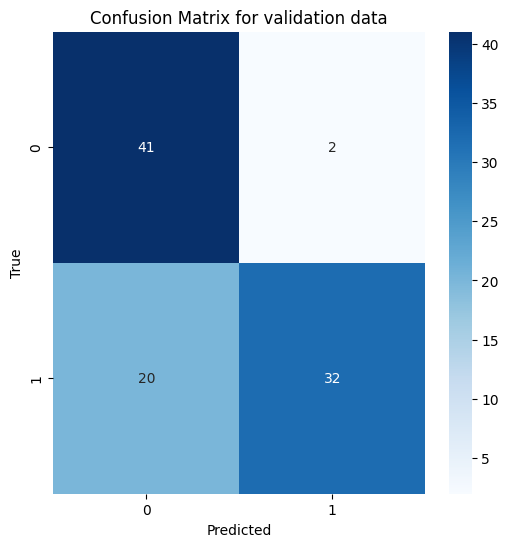

In [231]:
conf_matrix = confusion_matrix(y_valid, y_pred_svm)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for validation data')
plt.show()

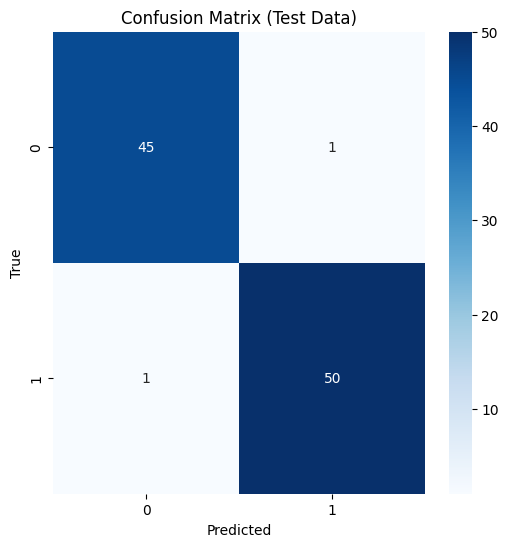

In [232]:
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Data)')
plt.show()

Cross-validation with SVM

In [233]:
cv_scores_res_svm = cross_val_score(best_model_svm, X_train_res, y_train_res, cv=tscv, scoring='roc_auc')
print(f"\nCross-Validation AUC After SMOTE and Tomek Links: {cv_scores_res_svm.mean():.4f} ± {cv_scores_res_svm.std():.4f}")


Cross-Validation AUC After SMOTE and Tomek Links: 0.8491 ± 0.2044


Evaluate model on original data

In [234]:
train_auc = metrics.roc_auc_score(y_train_res, best_model_svm.predict_proba(X_train_res)[:, 1])
valid_auc = metrics.roc_auc_score(y_valid, y_pred_proba_svm)
test_auc = metrics.roc_auc_score(y_test, y_test_proba)

print(f"\nSVM Model Performance (AUC):")
print(f"Training AUC: {train_auc:.4f}")
print(f"Validation AUC: {valid_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


SVM Model Performance (AUC):
Training AUC: 0.9045
Validation AUC: 0.9602
Test AUC: 0.9991


Comparison

1.AUC:

*SVM has a significantly higher Test AUC (0.9991) compared to Logistic Regression (0.9961). *Higher AUC suggests that SVM is better at distinguishing between classes across all threshold values.

2.Accuracy:

*SVM achieves higher Test Accuracy (0.98) than Logistic Regression Test Accuracy (0.94).

3.Precision, Recall, F1-Score:

*SVM has consistently higher scores (0.98) compared to Logistic Regression (0.94) on Test Data.

4.Validation Performance:

*Logistic Regression performs better in Validation Classification Report (Accuracy: 0.89) compared to SVM (Accuracy: 0.77).

*Logistic Regression shows better balance between classes in Validation Data.

5.Overfitting:

*SVM shows signs of potential overfitting since its performance drops on Validation Data (AUC: 0.9602) compared to Test Data (AUC: 0.9991). Logistic Regression appears more stable between Validation and Test Data.

Conclusion

*Test Performance is Critical

SVM is preferable, as it has higher AUC, Accuracy, and better classification metrics on the Test Data.

*Validation Performance is Important

Logistic Regression is more balanced, especially for unseen data (Validation Set), and less prone to overfitting.

Summary

Based on the given matrices SVM is better model when we prioritize overall test performance and higher AUC.

But according to my model, SVM may be overfitting because of that I think Logistic regression is better.